# Feldspar ternary classification diagram
*Jordan Lubbers , Penny Wieser* <br>
Making a function to create a feldspar ternary classification diagram as outlined in Deer, Howie, and Zussman (1963). Makes use of [```thermobar```](https://thermobar.readthedocs.io/en/latest/index.html) and [```ternary```](https://github.com/marcharper/python-ternary) packages.

In [1]:
#!pip install python-ternary

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ternary
import Thermobar as pt
from scipy import interpolate

In [3]:
# Import data
out1 = pt.import_excel("fsp_ternary_test.xlsx", sheet_name="Plag")
Plags = out1["Plags"]

out2 = pt.import_excel("fsp_ternary_test.xlsx", sheet_name="Kspar")
Kspars = out2["Kspars"]

In [4]:
# Use thermobar to get cation fractions
Kspar_Comps = pt.calculate_cat_fractions_kspar(kspar_comps=Kspars)
Plag_Comps = pt.calculate_cat_fractions_plagioclase(plag_comps=Plags)

In [8]:
# The function to create the classification diagram
def plot_fsp_classification(
    figsize,
    major_grid=False,
    minor_grid=False,
    labels=False,
    major_grid_kwargs={},
    minor_grid_kwargs={},
):
    """
    Plotting a feldspar ternary classification diagram according to Deer, Howie, and Zussman 1992 3rd edition.
    
    Inputs:
    figsize: tuple
    for figure size same as matplotlib
    
    major_grid: boolean,
    whether or not to show major grid lines shows lines every .2. Default = False
    
    minor_grid: boolean,
    whether or not to show minor grid lines...shows lines every .05. Default = False
    
    labels: boolean,
    whether or not to show abbreviated field labels for feldspar classification
    
    major_grid_kwargs: dict,
    inherited matplotlib kwargs for styling major grid
    
    minor_grid_kwargs: dict,
    inherited matplotlib kwargs for styling minor grid
    
    Returns:
    
    fig: matplotlib figure
    
    tax: ternary axis subplot from ternary package. To use matplotlib ax level styling
    and functions:
            # Example
            ax = tax.get_axes()
            ax.set_title('my title')
    
    
    """
    # plagioclase classification
    # anorthite      1.0 - 0.9
    # bytownite      0.9 - 0.7
    # labradorite    0.7 - 0.5
    # andesine       0.5 - 0.3
    # oligoclase     0.3 = 0.1
    # albite         0.1 - 0.0

    # figure and axis component
    figure, tax = ternary.figure()
    figure.set_size_inches(figsize)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=1.5,zorder = 0)  # outside triangle boundary width
    if major_grid is True:
        tax.gridlines(multiple=0.2, **major_grid_kwargs, zorder=0)
    if minor_grid is True:
        tax.gridlines(multiple=0.05, linewidth=0.5, **minor_grid_kwargs, zorder=0)
    # Set Axis labels and Title
    fontsize = 20
    tax.right_corner_label("An", fontsize=fontsize)
    tax.top_corner_label("Or", fontsize=fontsize)
    tax.left_corner_label("Ab", fontsize=fontsize)

    # making the plag curve
    An = np.array([1.0, 0.9, 0.7, 0.5, 0.3, 0.20, 0.15])
    Or = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.1, 0.15])
    f_plag = interpolate.interp1d(An, Or, kind="linear")
    An_new = np.linspace(0.15, 1, 1000)
    Or_new = f_plag(An_new)
    Ab_new = 1 - An_new
    plag_curve = np.hstack([An_new[:, None], Or_new[:, None], Ab_new[:, None]])

    # making plag - kspar line

    Or_kp = np.array([0, 0.15])
    An_kp = np.array([0, 0.15])
    Ab_kp = np.array([1, 0.85])

    f_kp = interpolate.interp1d(An_kp, Ab_kp)
    An_kp_new = np.linspace(0, 0.15, 1000)
    Or_kp_new = An_kp_new
    Ab_kp_new = An_kp_new
    plag_kspar_line = np.hstack(
        [An_kp_new[:, None], Or_kp_new[:, None], Ab_kp_new[:, None]]
    )

    # making the kspar curve
    Or_k = np.array([1.0, 0.37, 0.15])
    An_k = np.array([0.05, 0.05, 0.15])
    f_kspar = interpolate.interp1d(Or_k, An_k)
    Or_k_new = np.linspace(0.15, 1, 1000)
    An_k_new = f_kspar(Or_k_new)
    Ab_k_new = 1 - Or_k_new
    kspar_curve = np.hstack([An_k_new[:, None], Or_k_new[:, None], Ab_k_new[:, None]])

    # anorthite - bytownite divider
    tax.line([0.9, 0, 0], plag_curve[plag_curve[:, 0] >= 0.9][0], color="k")

    # bytownite - labradorite divider
    tax.line([0.7, 0, 0], plag_curve[plag_curve[:, 0] >= 0.7][0], color="k")

    # labradorite - andesine divider
    tax.line([0.5, 0, 0], plag_curve[plag_curve[:, 0] >= 0.5][0], color="k")

    # andesine - oligoclase divider
    tax.line([0.3, 0, 0], plag_curve[plag_curve[:, 0] >= 0.3][0], color="k")

    # oligoclase - albite divider
    tax.line([0.1, 0, 0], plag_kspar_line[plag_kspar_line[:, 0] >= 0.1][0], color="k")

    # sanidine - anorthoclase divider
    tax.line([0, 0.37, 0.63], kspar_curve[kspar_curve[:, 1] >= 0.37][0], color="k")

    # anorthoclase - albite divider
    tax.line([0, 0.1, 0.9], plag_kspar_line[plag_kspar_line[:, 0] >= 0.1][0], color="k")

    # making the plag - kspar divider
    tax.plot(plag_kspar_line[plag_kspar_line[:, 1] > 0.1], color="k")

    # plotting the curves
    tax.plot(plag_curve[:-60], color="k")
    tax.plot(kspar_curve[:-60], color="k")

    # Set ticks
    tax.ticks(
        axis="lbr", linewidth=0.5, multiple=0.20, offset=0.02, tick_formats="%.1f"
    )

    # # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis("off")
    tax._redraw_labels()

    if labels is True:
        # annotations
        ax = tax.get_axes()
        ax.text(0.3, 0.5, "San", rotation=60)
        ax.text(0.15, 0.2, "Ac")
        ax.text(0.05, 0.03, "Ab")
        ax.text(0.2, 0.03, "Ol")
        ax.text(0.38, 0.01, "Ad")
        ax.text(0.58, 0.01, "La")
        ax.text(0.78, 0.01, "By")
        ax.text(0.94, 0.01, "An")

    return figure, tax


# function to get arrays in proper format for plotting on ternary
def tern_points(right, top, left):
    """Tern_points takes 3 equal size 1D arrays or pandas series and organizes them into points to be plotted on a ternary
         with the following arrangement:(lower right,top,lower left).
             Inputs: 
             x = 1D array like (lower right vertex)
             y = 1D array like (top vertex)
             z = 1D array like (lower left vertex)
    """
    if isinstance(right, pd.Series):
        right = right.to_numpy()
    if isinstance(top, pd.Series):
        top = top.to_numpy()
    if isinstance(left, pd.Series):
        left = left.to_numpy()

    points = np.hstack([right[:, None], top[:, None], left[:, None]])

    return points

## Just the classification diagram
- San = Sanidine
- Ac = Anorthoclase
- Ab = Albite
- Ol = Oligoclase
- Ad = Andesine
- La = Labradorite
- By = Bytownite
- An = Anorthite

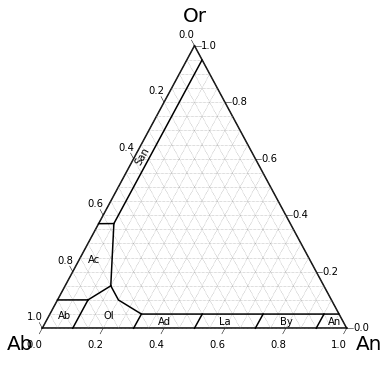

In [9]:
fig, tax = plot_fsp_classification(figsize = (6,6), labels = True,
                                   minor_grid = True,
                                   minor_grid_kwargs = {"color": "gray", "ls":":"}
                                  )


## Example plotting data on top of classification
...and some randome customizations to show flexibility

<AxesSubplot:>

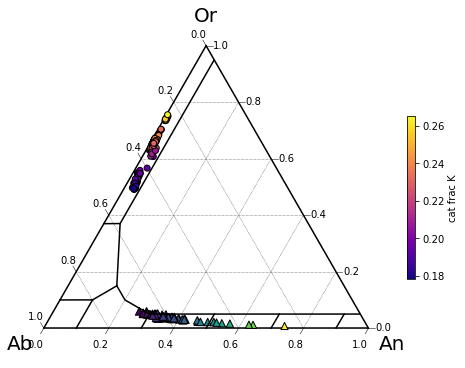

In [10]:
# Calling tern_points function for plag and kspar data
plag_points = tern_points(
    Plag_Comps["An_Plag"], Plag_Comps["Or_Plag"], Plag_Comps["Ab_Plag"]
)
kspar_points = tern_points(
    Kspar_Comps["An_Kspar"], Kspar_Comps["Or_Kspar"], Kspar_Comps["Ab_Kspar"]
)


# make the figure with the classification lines. Inherits from matplotlib similar to seaborn
# where we can control the appearance of the grid lines using dictionaries and plt kwargs
fig, tax = plot_fsp_classification(
    figsize=(8, 6), major_grid=True, major_grid_kwargs={"ls": ":", "lw": 0.5, "c": "k"}
)

# making the scatter plot..just exploring all the options
# scatter inherits from plt.scatter so we have all the freedom we want
# with that. Note we have to set the vmin and vmax because for some reason
# ternary.scatter defaults them to 0 and 1? dunno why
# also note I had to duplicate the colormap and cmap arguments below.
# cmap controls the color of the points and colormap controls the colorbar.
# kind of at the mercy of the ternary package here

tax.scatter(
    plag_points,
    c=Plag_Comps["Ca_Plag_cat_prop"],
    vmin=Plag_Comps["Ca_Plag_cat_prop"].min(),
    vmax=Plag_Comps["Ca_Plag_cat_prop"].max(),
    edgecolor="k",
    marker="^",
    s=Plag_Comps["SiO2_Plag"],
)
tax.scatter(
    kspar_points,
    c=Kspar_Comps["K_Kspar_cat_prop"],
    vmin=Kspar_Comps["K_Kspar_cat_prop"].min(),
    vmax=Kspar_Comps["K_Kspar_cat_prop"].max(),
    edgecolor="k",
    cmap="plasma",
    colorbar=True,
    colormap="plasma",
    cb_kwargs={"shrink": 0.5, "label": "cat frac K"},
)